# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [11]:
# !mkdir models
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
# !unzip -q UCI\ HAR\ Dataset.zip
#path = 'UCI HAR Dataset'
path = 'data'

In [12]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# import xgboost as xgb
# from xgboost import XGBClassifier, DMatrix
#!pip install catboost
# from catboost import Pool, CatBoostClassifier

import lightgbm as lgb
from tqdm.notebook import tqdm
import pickle
# !pip install scikit-plot

import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
X_train = np.genfromtxt(path + '/train/X_train.txt')
y_train = np.genfromtxt(path + '/train/y_train.txt') - 1

X_test = np.genfromtxt(path + '/test/X_test.txt')
y_test = np.genfromtxt(path + '/test/y_test.txt') - 1

with open(path + '/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]) - 1, x[1]) for x in activity_labels])

In [14]:
print('Соответствие между меткой и названием класса')
print('\n'.join('{} : {}'.format(key, value) for key, value in activity_labels.items()))

Соответствие между меткой и названием класса
0 : WALKING
1 : WALKING_UPSTAIRS
2 : WALKING_DOWNSTAIRS
3 : SITTING
4 : STANDING
5 : LAYING


Предобработку данных буду производить непосредственно в коде, поэтому удалил некоторые строки.

In [15]:
print('Размер выборки: {} \nКоличество фичей: {}'.format(*X_train.shape))

Размер выборки: 7352 
Количество фичей: 561


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [16]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except OSError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train = X_train[:, unique_columns]
X_test = X_test[:, unique_columns]

In [17]:
print('Число уникальных фичей: {}'.format(X_train.shape[1]))

Число уникальных фичей: 540


Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

### Решение.

In [18]:
def calculate_metrics(y_true, y_pred):
    print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Recall: {}'.format(recall_score(y_test, y_pred, average='macro')))
    print('F1: {}'.format(f1_score(y_test, y_pred, average='macro')))

Для начала построим `baseline` модель, в дальнейшем можно будет смотреть, каких улучшений мы смогли добиться.  
В данном случае, у нас задача классификация на 6 классов, самый простой способ - использовать логистическую регрессию.  
Для подбора оптимальных параметров воспользуемся поиском по сетке.  
Вспомним, что в данных очень много фичей, но на качество логистической регрессии это не должно сильно влиять.  
Но все равно, построим модель и для исходных данных, и для данных, к которым применили PCA.

Логистическая регрессия, данные без PCA

In [0]:
logreg_pipe = Pipeline([('sc', StandardScaler()),
                        ('clf', LogisticRegression(max_iter=500, solver='saga', random_state=42))])

logreg_params = {'clf__penalty' : ['l1', 'l2'],
                 'clf__C' : [0, 0.001, 0.01, 0.1, 1, 10, 100]}

logreg_pipe = GridSearchCV(logreg_pipe, logreg_params, n_jobs=-1, verbose=10)
logreg_pipe.fit(X_train, y_train)
logreg_model = logreg_pipe.best_estimator_

calculate_metrics(y_test, logreg_model.predict(X_test))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 19.7min finished


Accuracy: 0.9453681710213777
Precision: 0.948886557528129
Recall: 0.9445512640047307
F1: 0.9457312122044318


/home/egor/anaconda3/envs/mipt-stats/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
pickle.dump(logreg_model, open('models/logreg.sav', 'wb'))

Как видно, мы получили очень хорошее качество. Давайте посмотрим, сколько фичей наша модель посчитала ненужными и занулила коэффициенты перед ними.

In [0]:
print('Количество фичей с нулевыми коэффициентами: {}'.format((logreg_model.steps[1][1].coef_ == 0).sum()))

Количество фичей с нулевыми коэффициентами: 1515


То есть в среднем, в каждой из моделей (т.к. классификация на 6 классов, то моделей 6) по 250 признаков оказались зануленными.

Логистическая регрессия, данные с PCA

In [0]:
logreg_pca_pipe = Pipeline([('sc', StandardScaler()),
                            ('pca', PCA(0.99)),
                            ('clf', LogisticRegression(max_iter=500, solver='saga', random_state=42))])

logreg_pca_params = {'clf__penalty' : ['l1', 'l2'],
                     'clf__C' : [0, 0.001, 0.01, 0.1, 1, 10, 100]}

logreg_pca_pipe = GridSearchCV(logreg_pca_pipe, logreg_pca_params, n_jobs=-1, verbose=10)
logreg_pca_pipe.fit(X_train, y_train)
logreg_pca_model = logreg_pca_pipe.best_estimator_

calculate_metrics(y_test, logreg_pca_model.predict(X_test))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  6.4min finished


Accuracy: 0.9426535459789617
Precision: 0.9459328526954619
Recall: 0.9417260033543497
F1: 0.9429666723330435


/home/egor/anaconda3/envs/mipt-stats/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
pickle.dump(logreg_pca_model, open('models/logreg_pca.sav', 'wb'))

Обученные модели логистической регрессии показали очень хорошее качество, причем модель с PCA обучается в 3 раза быстрее, а прирост совсем незначительный.

Когда говорим о логистической регрессии, нельзя говорить о сложности модели, потому что гиперпараметры не усложняют модель.  
Поэтому графиков зависимости метрик от сложности моделей не будет начерчено, но `roc-auc` кривые построить можно.

<Figure size 1440x720 with 0 Axes>

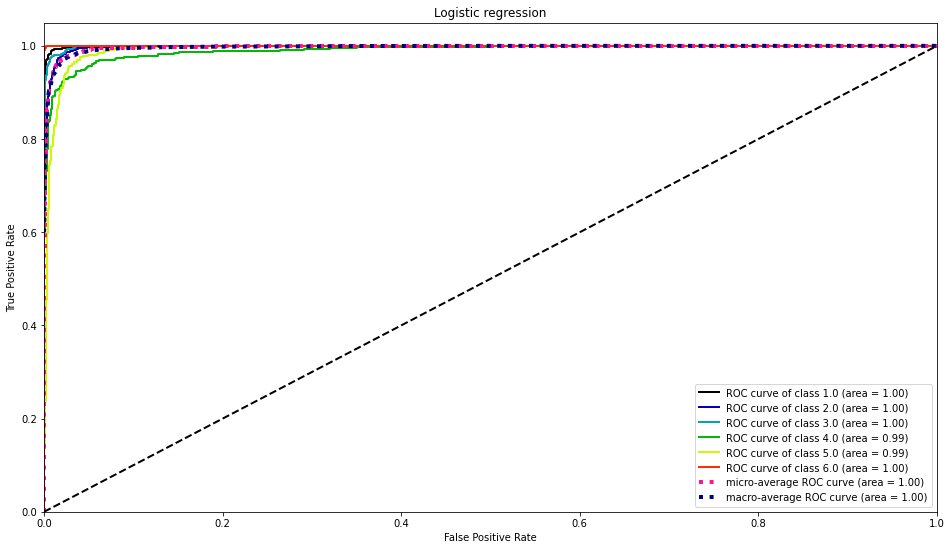

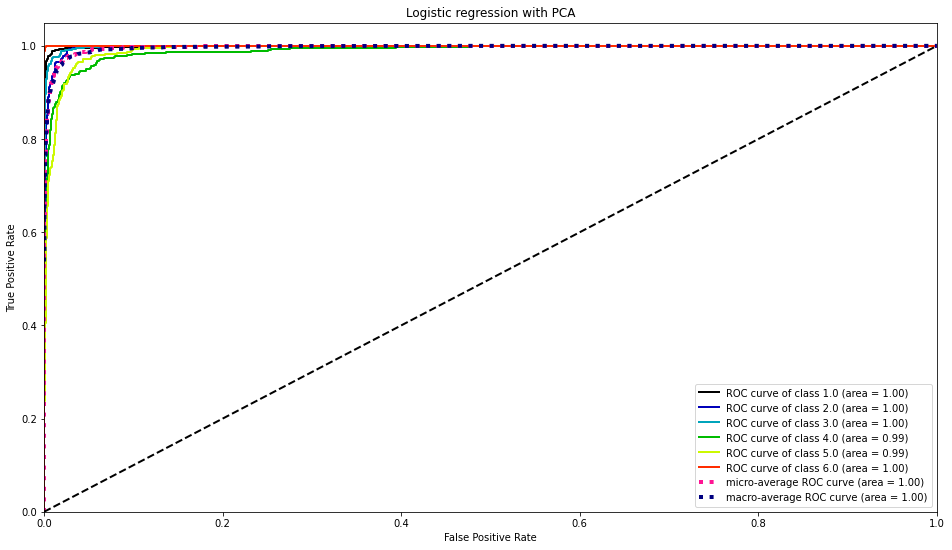

In [0]:
models = [logreg_model, logreg_pca_model]
titles = ['Logistic regression', 'Logistic regression with PCA']

plt.figure(figsize=(20, 10))
for i in range(2):
    skplt.metrics.plot_roc(y_test, models[i].predict_proba(X_test), figsize=(16, 9))
    plt.title(titles[i])
    plt.show()

Как видно, площадь под кривыми почти равна единице по всем классам - это очень хороший результат, при этом для обучения обеих моделей не потребовалось никаких нетривиальных действий.

***С этого момента буду пробовать модели, основанные на деревьях***

Начнем с более простой модели - `Random Forest`.  
Как известно, эта модель представляет из себя композицию переобученных решающих деревьев, каждое из которых обучается независимо, а итоговое предсказание - среднее по всем деревьям.  
В случае классификации будут усредняться вероятности, и ответ будет предсказываться как `argmax` по всем классам.  
В случае `Random Forest` данные не нуждаются в стандартизации.  
С увеличением количества деревьев время обучения линейно увеличивается, при этом начиная с какого-то количества качество перестает расти.  
Поэтому при обучении заранее выберу количество деревьев, равное 200.

In [0]:
rf_params = {'criterion' : ['gini', 'entropy'],
             'max_depth' : np.arange(5, 20, 2),
             'min_samples_split' : [2, 4, 6]}

rf_pipe = GridSearchCV(RandomForestClassifier(n_estimators=200, random_state=42), rf_params, n_jobs=-1, verbose=3, cv=3)
rf_pipe.fit(X_train, y_train)
rf_model = rf_pipe.best_estimator_

calculate_metrics(y_test, rf_model.predict(X_test))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 12.0min finished


Accuracy: 0.9351883271123176
Precision: 0.9362156082032623
Recall: 0.9316985985610508
F1: 0.932952771409933


In [0]:
pickle.dump(rf_model, open('models/rf.sav', 'wb'))

Как видно, решающий лес классифицирует хуже, чем логистическая регрессия.  
Тут можно вспомнить, что при разбиении вершины рандомно генерируется $\sqrt{d}$ признаков.  
Учитывая, что в нашем датасете признаков 540, из которых даже логистическая регрессия занулила порядка 200, можно сделать предположение, что многие из них могут быть бесполезными.  
А значит, при разбиении велик шанс, что из примерно 23 выбранных признаков, они окажутся не сильно значимыми.  
И если в дереве такое будет случаться часто, то оно будет предсказывать достаточно плохо, и общее качество предсказаний ухудшится.  
Поэтому в данном случае может помочь PCA, он оставит меньшее число признаков, при этом количество перебираемых уменьшится в $\sqrt{t}$ раз, где $t$ - отношение числа признаков в исходном датасете к числу признаков в датасете, к которому применили PCA.  
Из того, что число перебираемых признаков уменьшается не линейно, а как корень, RF с PCA выглядит более выгодно.

In [0]:
rf_pca_pipe = Pipeline([('sc', StandardScaler()),
                        ('pca', PCA(0.99)),
                        ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

rf_pca_params = {'clf__criterion' : ['gini', 'entropy'],
                 'clf__max_depth' : np.arange(5, 20, 2),
                 'clf__min_samples_split' : [2, 4, 6]}

rf_pca_pipe = GridSearchCV(rf_pca_pipe, rf_pca_params, n_jobs=-1, verbose=3, cv=3)
rf_pca_pipe.fit(X_train, y_train)
rf_pca_model = rf_pca_pipe.best_estimator_

calculate_metrics(y_test, rf_pca_model.predict(X_test))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 12.5min finished


Accuracy: 0.8941296233457754
Precision: 0.8979842953822348
Recall: 0.889232169220444
F1: 0.890387797348068


In [0]:
pickle.dump(rf_pca_model, open('models/rf_pca.sav', 'wb'))

Как видно, предположения выше не подтвердились :С

Построим `roc-auc` кривую для `Random Forest` без PCA

<Figure size 864x576 with 0 Axes>

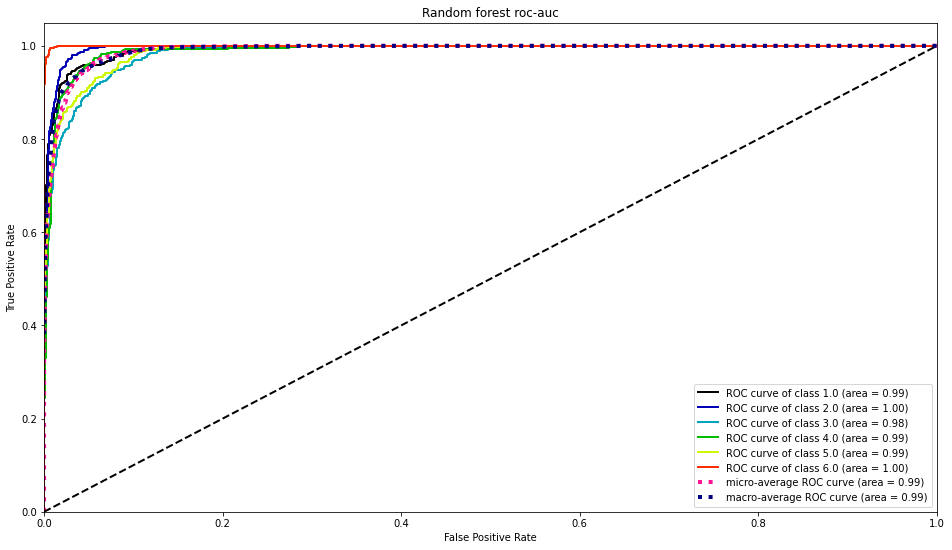

In [0]:
plt.figure(figsize=(12, 8))
skplt.metrics.plot_roc(y_test, rf_pca_model.predict_proba(X_test), figsize=(16, 9))
plt.title('Random forest roc-auc')
plt.show()

Выглядит тоже неплохо, но хуже чем у логистической регрессии.

Наиболее логично измерять сложность `RF` по двум критериям: максимальной глубине и количеству деревьев.  
Количество деревьев напрямую влияет на скорость обучения и предсказывания, максимальная глубина - на то, насколько сложные зависимости мы вообще способны предсказывать.
Параметры, касающиеся `stop`-моментов (когда нельзя делить вершину на дочерние), достаточно сильно коррелируют с максимальной глубиной, а ее измерить проще.  
Параметр `max features` можно тоже отнести к сложности, но на самом деле он не влияет напрямую -- он вносит элемент случайности в построение деревьев, делая деревья более разными. И при любом его значении (отличным от 1), можно получить одну и ту же композицию деревьев, поэтому не буду рассматривать его в сложности.

In [10]:
def plot_dependence(model, params, param_name, grid):
    '''
    Рисует зависимость метрики от значения параметра param_name по grid
    model : model or pipeline
    '''
    accuracy = []
    recall = []
    precision = []
    f1 = []
    for value in tqdm(grid):
        params[param_name] = value
        md = model(**params)
        md.fit(X_train, y_train)
        
        accuracy.append(accuracy_score(y_test, md.predict(X_test)))
        recall.append(recall_score(y_test, md.predict(X_test), average='macro'))
        precision.append(precision_score(y_test, md.predict(X_test), average='macro'))
        f1.append(f1_score(y_test, md.predict(X_test), average='macro'))
        
    plt.plot(grid, accuracy, label='accuracy')
    plt.plot(grid, recall, label='recall')
    plt.plot(grid, precision, label='precision')
    plt.plot(grid, f1, label='f1')
    plt.xlabel(param_name)
    plt.ylabel('Значение метрики')
    plt.title('Зависимость метрик от {}'.format(param_name))
    plt.legend()

Построим зависимость метрик от количества деревьев.

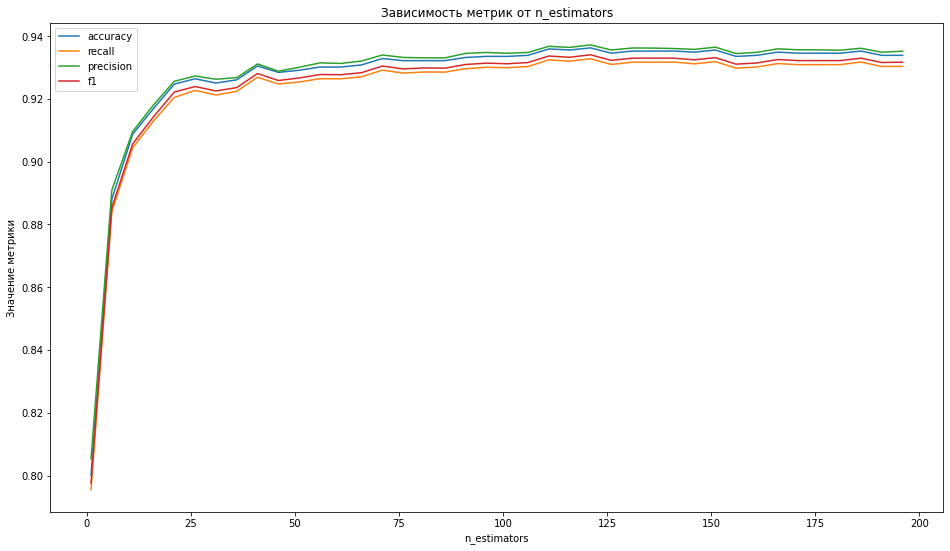

In [0]:
params = {'n_estimators' : 200,
          'random_state' : 42, 
          'criterion' : 'entropy',
          'max_depth' : 15,
          'min_samples_split' : 4,
          'n_jobs' : -1}

plt.figure(figsize=(16, 9))
plot_dependence(RandomForestClassifier, 
                params, 
                'n_estimators',
                np.arange(1, 200, 5))
plt.show()

Как Видно, начиная со 110 деревьев не видно существенного прироста.  
Поэтому 200 деревьев даже много для данной задачи, можно было остановиться на ~100.

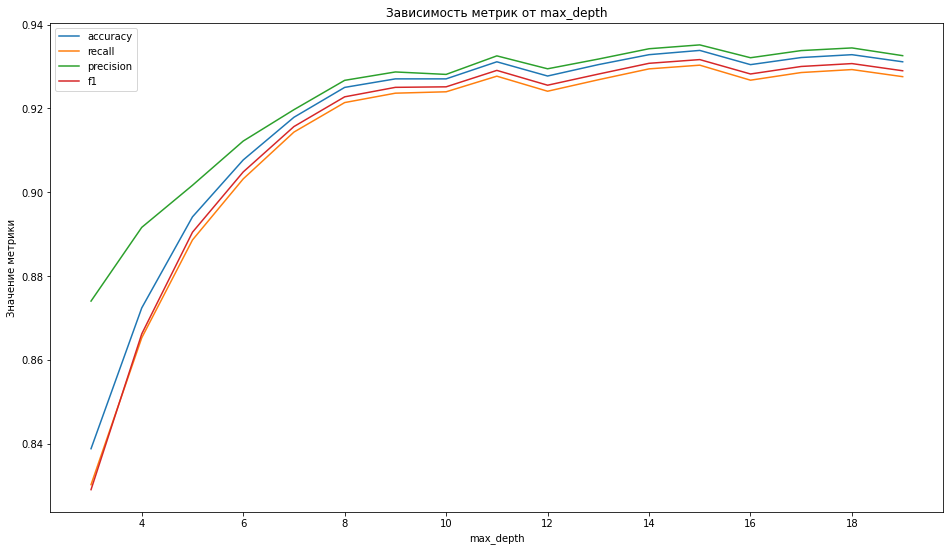

In [0]:
plt.figure(figsize=(16, 9))

plot_dependence(RandomForestClassifier, 
                params, 
                'max_depth',
                np.arange(3, 20, 1))

plt.show()

Как видно, при маленькой глубине деревья оказываются недообученными, а потом метрика увеличивается, и в какой-то момент начинает почти не меняться. При это на глубине 15 метрика получается наилучшей.

##### Настало время бустингов  
Чтобы быстрее обучать модели, буду использовать GPU на colab  
Но от этого результаты станут менее воспроизводимыми, но значения метрик будут менять очень несущественно.

***XGBoost***

Перебирать все параметры по сетке -- очень долго, будем делать это последовательно

In [0]:
xgb_params = {"num_class": 6, 
              "booster": "gbtree",
              "n_estimators": 1000,
              "learning_rate": 0.1,
              "max_depth": 5,
              "min_child_weight": 1,
              "gamma": 0.1,
              "subsample": 0.8,
              "colsample_bytree": 0.8,
              "tree_method" : 'gpu_hist',
              "nthread" : -1}

Сначала определим оптимальное количество деревьев: то, после которого уже начинается переобучение.

In [0]:
xgtrain = xgb.DMatrix(X_train, y_train)
xgtest = xgb.DMatrix(X_test, y_test)
evallist = [(xgtest, 'eval'), (xgtrain, 'train')]

In [0]:
%%time
xgb_model = XGBClassifier()
cvresult = xgb.cv(xgb_params, 
                  xgtrain, 
                  num_boost_round=xgb_params['n_estimators'],
                  nfold=5, early_stopping_rounds=30)
# xgb_model = XGBClassifier(silent=True, max_depth=10, n_estimators=100, n_jobs=-1, tree_method='gpu_hist', )
# xgb_model.fit(X_train, y_train)

CPU times: user 49.2 s, sys: 30.6 s, total: 1min 19s
Wall time: 1min 19s


In [0]:
cvresult[-3:]

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
203,0.0,0.0,0.006936,0.001572
204,0.0,0.0,0.007072,0.001750
205,0.0,0.0,0.006800,0.001424


После добавления 206 дерева метрика перестала падать, поэтому выберем `n_estimators` = 205

Настроим параметры `max_depth` и `min_child_weight`, они наиболее сильно влияют на итоговое качество

In [0]:
param_grid = {
    "max_depth" : range(3, 7),
    "min_child_weight" : range(1, 6)
}

xgb_params = {"num_class": 6, 
              "booster": "gbtree",
              "n_estimators": 205,
              "learning_rate": 0.1,
              "gamma": 0.1,
              "subsample": 0.8,
              "colsample_bytree": 0.8,
              "tree_method" : 'gpu_hist',
              "nthread" : -1}

In [0]:
gs = GridSearchCV(XGBClassifier(**xgb_params), param_grid, n_jobs=4, scoring='accuracy', verbose=10, cv=3)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 11.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 11.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=205, n_jobs=1,
                                     nthread=-1, num_class=6,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': range(3, 7),
              

In [0]:
gs.best_params_

{'max_depth': 4, 'min_child_weight': 5}

Теперь настроим `gamma`

In [0]:
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
}

xgb_params = {"num_class": 6, 
              "booster": "gbtree",
              "n_estimators": 205,
              "max_depth" : 4,
              "min_child_weight" : 5,
              "learning_rate": 0.1,
              "subsample": 0.8,
              "colsample_bytree": 0.8,
              "tree_method" : 'gpu_hist',
              "nthread" : -1}

In [0]:
gs = GridSearchCV(XGBClassifier(**xgb_params), param_grid, n_jobs=4, scoring='accuracy', verbose=10, cv=3)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.4min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed:  2.9min remaining:  1.1min
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:  2.9min remaining:   34.9s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  3.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=5,
                                     missing=None, n_estimators=205, n_jobs=1,
                                     nthread=-1, num_class=6,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]},
  

In [0]:
gs.best_params_

{'gamma': 0}

Настроим параметры сэмплирования

In [0]:
param_grid = {
    "subsample": [0.4, 0.6, 0.8, 0.9],
    "colsample_bytree": [0.4, 0.6, 0.8, 0.9],
}

xgb_params = {"num_class": 6, 
              "booster": "gbtree",
              "n_estimators": 205,
              "max_depth" : 4,
              "min_child_weight" : 5,
              "learning_rate": 0.1,
              "gamma": 0,
              "tree_method" : 'gpu_hist',
              "nthread" : -1}

In [0]:
gs = GridSearchCV(XGBClassifier(**xgb_params), param_grid, n_jobs=4, scoring='accuracy', verbose=10, cv=3)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  46 out of  48 | elapsed:  8.3min remaining:   21.7s
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:  8.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=5,
                                     missing=None, n_estimators=205, n_jobs=1,
                                     nthread=-1, num_class=6,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8, 0.9],
    

In [0]:
gs.best_params_

{'colsample_bytree': 0.9, 'subsample': 0.4}

Параметры регуляризации

In [0]:
param_grid = {
    'alpha': [0, 0.001, 0.005, 0.01, 0.05],
    'lambda': [0, 0.001, 0.005, 0.01, 0.05],
}

xgb_params = {"num_class": 6, 
              "booster": "gbtree",Н
              "n_estimators": 205,
              "max_depth" : 4,
              "min_child_weight" : 5,
              "subsample": 0.9,
              "colsample_bytree": 0.4,
              "learning_rate": 0.1,
              "gamma": 0,
              "tree_method" : 'gpu_hist',
              "nthread" : -1}

In [0]:
gs = GridSearchCV(XGBClassifier(**xgb_params), param_grid, n_jobs=4, scoring='accuracy', verbose=10, cv=3)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.2min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  9.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 10.6min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 12.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.4, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=5,
                                     missing=None, n_estimators=205, n_jobs=1,
                                     nthread=-1, num_class=6,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.9, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': [0, 0.001, 0.005, 0.01, 0.05],
  

In [0]:
gs.best_params_

{'alpha': 0, 'lambda': 0}

Обучим модель с лучшими параметрами

In [0]:
xgb_model = gs.best_estimator_
xgb_model.fit(X_train, y_train)
calculate_metrics(y_test, xgb_model.predict(X_test))

Accuracy: 0.9484221241940957
Precision: 0.9498640268981591
Recall: 0.9467435045811601
F1: 0.9477070152941972


In [0]:
pickle.dump(xgb_model, open("xgb.dat", "wb"))

Получили значения всех метрик лучше, чем логистической регрессией.  
Baseline побит, уже хорошо.

***Catboost***

Одно из главных преимуществ `catboost` - умная работа с категориальными фичами, но в данном датасете явно указать их нет возможности. 
Повторим такой же цикл обучения, что и с `xgboost`

Выберем количество деревьев

In [0]:
param_grid = {
    'iterations' : [100, 200, 400 , 600, 800, 1000]
}
catboost_params = {"classes_count": 6,
                   "learning_rate": 0.1,
                   "depth": 5,
                   "l2_leaf_reg": 1,
                   'task_type' :'GPU'}

In [0]:
%%time
gs_catboost = GridSearchCV(CatBoostClassifier(**catboost_params, eval_metric='Accuracy', silent=True), param_grid, verbose=5)
# catboost_model = CatBoostClassifier(**catboost_params, eval_metric='Accuracy')
gs_catboost.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] iterations=100 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... iterations=100, score=0.890, total=   2.1s
[CV] iterations=100 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ...................... iterations=100, score=0.910, total=   2.5s
[CV] iterations=100 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] ...................... iterations=100, score=0.931, total=   2.4s
[CV] iterations=100 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s remaining:    0.0s


[CV] ...................... iterations=100, score=0.956, total=   2.4s
[CV] iterations=100 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.4s remaining:    0.0s


[CV] ...................... iterations=100, score=0.935, total=   2.5s
[CV] iterations=200 ..................................................
[CV] ...................... iterations=200, score=0.906, total=   3.4s
[CV] iterations=200 ..................................................
[CV] ...................... iterations=200, score=0.908, total=   3.5s
[CV] iterations=200 ..................................................
[CV] ...................... iterations=200, score=0.937, total=   3.5s
[CV] iterations=200 ..................................................
[CV] ...................... iterations=200, score=0.963, total=   3.4s
[CV] iterations=200 ..................................................
[CV] ...................... iterations=200, score=0.942, total=   3.4s
[CV] iterations=400 ..................................................
[CV] ...................... iterations=400, score=0.918, total=   5.3s
[CV] iterations=400 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.2min finished


CPU times: user 3min 41s, sys: 2min 14s, total: 5min 55s
Wall time: 3min 21s


In [0]:
print(gs_catboost.best_params_)
catboost_model = gs_catboost.best_estimator_

{'iterations': 1000}


In [0]:
calculate_metrics(y_test, catboost_model.predict(X_test))

Accuracy: 0.9399389209365456
Precision: 0.9418962802822298
Recall: 0.9386568043365112
F1: 0.9396356070871613


Подберем глубину

In [0]:
param_grid = {
    "depth": [4, 5, 6, 7, 8]
}
catboost_params = {"classes_count": 6,
                   'iterations' : 1000,
                   "learning_rate": 0.1,
                   "l2_leaf_reg": 1,
                   'task_type' :'GPU'}

In [0]:
%%time
gs_catboost = GridSearchCV(CatBoostClassifier(**catboost_params, eval_metric='Accuracy', silent=True), 
                           param_grid, 
                           verbose=3, 
                           n_jobs=1,
                           cv=3)
# catboost_model = CatBoostClassifier(**catboost_params, eval_metric='Accuracy')
gs_catboost.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] depth=4 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. depth=4, score=0.938, total=   7.9s
[CV] depth=4 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] ............................. depth=4, score=0.911, total=   8.3s
[CV] depth=4 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s


[CV] ............................. depth=4, score=0.940, total=   8.0s
[CV] depth=5 .........................................................
[CV] ............................. depth=5, score=0.936, total=  10.4s
[CV] depth=5 .........................................................
[CV] ............................. depth=5, score=0.914, total=  10.4s
[CV] depth=5 .........................................................
[CV] ............................. depth=5, score=0.939, total=  10.3s
[CV] depth=6 .........................................................
[CV] ............................. depth=6, score=0.940, total=  13.9s
[CV] depth=6 .........................................................
[CV] ............................. depth=6, score=0.908, total=  13.8s
[CV] depth=6 .........................................................
[CV] ............................. depth=6, score=0.936, total=  14.0s
[CV] depth=7 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.2min finished


CPU times: user 4min 3s, sys: 3min 44s, total: 7min 48s
Wall time: 4min 20s


In [0]:
print(gs_catboost.best_params_)
catboost_model = gs_catboost.best_estimator_
calculate_metrics(y_test, catboost_model.predict(X_test))

{'depth': 5}
Accuracy: 0.9399389209365456
Precision: 0.9418962802822298
Recall: 0.9386568043365112
F1: 0.9396356070871613


Наконец, выберем параметр регуляризации

In [0]:
param_grid = {
    "l2_leaf_reg": [0.01, 0.1, 1, 10],
}
catboost_params = {"classes_count": 6,
                   'iterations' : 1000,
                   "learning_rate": 0.1,
                   "depth": 5,
                   'task_type' :'GPU'}

gs_catboost = GridSearchCV(CatBoostClassifier(**catboost_params, eval_metric='Accuracy', silent=True), 
                           param_grid, 
                           verbose=3)
# catboost_model = CatBoostClassifier(**catboost_params, eval_metric='Accuracy')
gs_catboost.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] l2_leaf_reg=0.01 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... l2_leaf_reg=0.01, score=0.927, total=   9.9s
[CV] l2_leaf_reg=0.01 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] .................... l2_leaf_reg=0.01, score=0.909, total=  10.4s
[CV] l2_leaf_reg=0.01 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s


[CV] .................... l2_leaf_reg=0.01, score=0.949, total=  10.4s
[CV] l2_leaf_reg=0.01 ................................................
[CV] .................... l2_leaf_reg=0.01, score=0.975, total=  10.3s
[CV] l2_leaf_reg=0.01 ................................................
[CV] .................... l2_leaf_reg=0.01, score=0.939, total=  10.5s
[CV] l2_leaf_reg=0.1 .................................................
[CV] ..................... l2_leaf_reg=0.1, score=0.924, total=  10.4s
[CV] l2_leaf_reg=0.1 .................................................
[CV] ..................... l2_leaf_reg=0.1, score=0.908, total=  10.3s
[CV] l2_leaf_reg=0.1 .................................................
[CV] ..................... l2_leaf_reg=0.1, score=0.947, total=  10.5s
[CV] l2_leaf_reg=0.1 .................................................
[CV] ..................... l2_leaf_reg=0.1, score=0.972, total=  10.5s
[CV] l2_leaf_reg=0.1 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fba447155c0>,
             iid='deprecated', n_jobs=None,
             param_grid={'l2_leaf_reg': [0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [0]:
print(gs_catboost.best_params_)
catboost_model = gs_catboost.best_estimator_
calculate_metrics(y_test, catboost_model.predict(X_test))

{'l2_leaf_reg': 0.01}
Accuracy: 0.9355276552426196
Precision: 0.9378766768868902
Recall: 0.9341785216850385
F1: 0.9351294803219438


### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

In [0]:
# Your code here

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

In [0]:
# Your code here.